# Exploring flux data and environmental covariables

tern data: https://portal.tern.org.au/#/4c2fa2f1

## Load modules

In [1]:
# !pip install dea-tools==0.2.4
# !pip install odc-algo==0.2.2
# !pip install mlforecast

In [2]:
import xarray as xr
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import datacube
import math
from dea_tools.datahandling import load_ard, mostcommon_crs
from dea_tools.bandindices import calculate_indices

## Analysis Parameters

In [3]:
base='https://dap.tern.org.au/thredds/dodsC/ecosystem_process/ozflux/'
# suffix='Tumbarumba/2021_v1/L6/default/Tumbarumba_L6_20020107_20191231_Monthly.nc'
suffix='Whroo/2021_v1/L6/default/Whroo_L6_20111201_20210724_Monthly.nc'

## Load flux data through THREDDS

In [4]:
flux = xr.open_dataset(base+suffix)
flux.data_vars

Data variables:
    AH        (time, latitude, longitude) float64 ...
    CO2       (time, latitude, longitude) float64 ...
    ER_LT     (time, latitude, longitude) float64 ...
    ER_SOLO   (time, latitude, longitude) float64 ...
    ET        (time, latitude, longitude) float64 ...
    Fco2      (time, latitude, longitude) float64 ...
    Fe        (time, latitude, longitude) float64 ...
    Fg        (time, latitude, longitude) float64 ...
    Fh        (time, latitude, longitude) float64 ...
    Fld       (time, latitude, longitude) float64 ...
    Flu       (time, latitude, longitude) float64 ...
    Fn        (time, latitude, longitude) float64 ...
    Fsd       (time, latitude, longitude) float64 ...
    Fsu       (time, latitude, longitude) float64 ...
    GPP_LT    (time, latitude, longitude) float64 ...
    GPP_SOLO  (time, latitude, longitude) float64 ...
    NEE_LT    (time, latitude, longitude) float64 ...
    NEE_SOLO  (time, latitude, longitude) float64 ...
    NEP_LT  

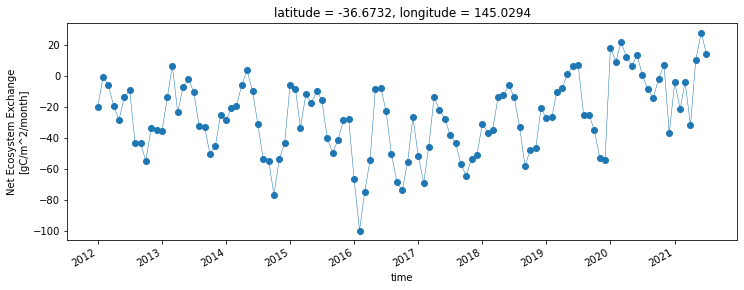

In [5]:
flux.NEE_LT.plot(figsize=(12,4), marker='o', linewidth=0.5);

## Load Satellite NDVI data at same location

In [6]:
dc = datacube.Datacube(app='Using_load_ard')

In [7]:
# Create the 'query' dictionary object, which contains the longitudes, 
# latitudes and time provided above
query = {
    'y': flux.latitude.values[0],
    'x': flux.longitude.values[0],
    'time': (np.datetime_as_string(flux.time.values[0], unit='D'),np.datetime_as_string(flux.time.values[-1], unit='D')),
    'measurements': ['nbart_red', 'nbart_nir'],
    'resolution': (-100, 100),
}

# Identify the most common projection system in the input query 
output_crs = mostcommon_crs(dc=dc, product='ga_ls8c_ard_3', query=query)

# Load available data from all three Landsat satellites
ds = load_ard(dc=dc,
              products=['ga_ls5t_ard_3', 'ga_ls7e_ard_3', 'ga_ls8c_ard_3'],
              #mask_filters = [("opening", 4), ("dilation", 2)],
              output_crs=output_crs,
              group_by='solar_day',
              **query
             )

Finding datasets
    ga_ls5t_ard_3
    ga_ls7e_ard_3
    ga_ls8c_ard_3
Applying pixel quality/cloud mask
Loading 548 time steps


### Caclulate NDVI and resample to monthly

In [8]:
ndvi = calculate_indices(ds, 'NDVI', collection='ga_ls_3', drop=True).NDVI

Dropping bands ['nbart_red', 'nbart_nir']


In [9]:
ndvi = ndvi.resample(time='MS').median()

### Match NDVI time-series with Flux measurements

In [10]:
ndvi = ndvi.reindex(time=flux.time, method='nearest')

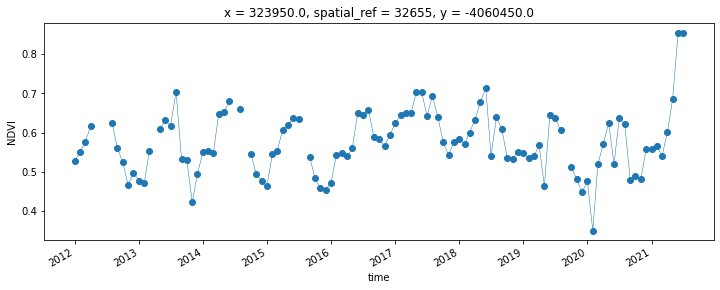

In [11]:
ndvi.plot(figsize=(12,4),marker='o', linewidth=0.5);

In [12]:
ndvi.to_dataframe()

,,,spatial_ref,NDVI
time,y,x,,
2012-01-01 00:30:00,-4060450.0,323950.0,32655,0.528152
2012-02-01 00:30:00,-4060450.0,323950.0,32655,0.550767
2012-03-01 00:30:00,-4060450.0,323950.0,32655,0.575626
2012-04-01 00:30:00,-4060450.0,323950.0,32655,0.616123
2012-05-01 00:30:00,-4060450.0,323950.0,32655,NaN
...,...,...,...,...
2021-03-01 00:30:00,-4060450.0,323950.0,32655,0.539516
2021-04-01 00:30:00,-4060450.0,323950.0,32655,0.600910
2021-05-01 00:30:00,-4060450.0,323950.0,32655,0.685798


## Stack all variables into dataframe

In [15]:
nee = flux.NEE_LT.to_dataframe().reset_index(level=[1,2]).drop(['latitude','longitude'],axis=1)
ts = flux.Ts.to_dataframe().reset_index(level=[1,2]).drop(['latitude','longitude'],axis=1)
ta = flux.Ta.to_dataframe().reset_index(level=[1,2]).drop(['latitude','longitude'],axis=1)
sws = flux.Sws.to_dataframe().reset_index(level=[1,2]).drop(['latitude','longitude'],axis=1)
rh = flux.RH.to_dataframe().reset_index(level=[1,2]).drop(['latitude','longitude'],axis=1)
vp = flux.VP.to_dataframe().reset_index(level=[1,2]).drop(['latitude','longitude'],axis=1)
fn = flux.Fn.to_dataframe().reset_index(level=[1,2]).drop(['latitude','longitude'],axis=1)
ndvi = ndvi.to_dataframe().reset_index(level=[1,2]).drop(['y','x', 'spatial_ref'],axis=1)

In [16]:
df = nee.join([ts,ta,sws,rh,vp,fn, ndvi])
df= df.dropna()
df.head()

,NEE_LT,Ts,Ta,Sws,RH,VP,Fn,NDVI
time,,,,,,,,
2012-01-01 00:30:00,-20.001073,26.467100,22.585355,0.144895,50.384173,1.307236,198.688294,0.528152
2012-02-01 00:30:00,-0.386153,23.714783,21.607265,0.183575,58.973737,1.442199,154.353222,0.550767
2012-03-01 00:30:00,-5.901736,19.447002,18.162215,0.256637,65.767715,1.349579,120.463186,0.575626
2012-04-01 00:30:00,-19.220721,16.048009,15.897760,0.152340,66.813775,1.186304,74.292632,0.616123
2012-08-01 00:30:00,-43.225247,9.181373,9.424770,0.205343,75.458631,0.881281,54.884059,0.625358


### Calculate Vapour pressure deficit


In [17]:
def VPD(rh, ta):
    sat_vp = (6.11 * xr.ufuncs.exp((2500000/461) * (1/273 - 1/(273 + ta))))
    vpd = (((100 - rh)/100) * sat_vp)
    return vpd / 10 # go from mb to kPA

In [18]:
df['VPD'] = VPD(df.RH,df.Ta)
df = df.drop('VP', axis=1)#drop VP

### Add lags


In [19]:
df_lag1  = df.drop('NEE_LT', axis=1).shift(1)
# df_lag2  = df.drop('NEE_LT', axis=1).shift(2)

In [20]:
df = df.join(df_lag1, rsuffix='_lag1')
# df = df.join(df_lag2, rsuffix='_lag2')

In [21]:
df= df.dropna()
df.head()

,NEE_LT,Ts,Ta,Sws,RH,Fn,NDVI,VPD,Ts_lag1,Ta_lag1,Sws_lag1,RH_lag1,Fn_lag1,NDVI_lag1,VPD_lag1
time,,,,,,,,,,,,,,,
2012-02-01 00:30:00,-0.386153,23.714783,21.607265,0.183575,58.973737,154.353222,0.550767,1.076047,26.467100,22.585355,0.144895,50.384173,198.688294,0.528152,1.383065
2012-03-01 00:30:00,-5.901736,19.447002,18.162215,0.256637,65.767715,120.463186,0.575626,0.722131,23.714783,21.607265,0.183575,58.973737,154.353222,0.550767,1.076047
2012-04-01 00:30:00,-19.220721,16.048009,15.897760,0.152340,66.813775,74.292632,0.616123,0.604972,19.447002,18.162215,0.256637,65.767715,120.463186,0.575626,0.722131
2012-08-01 00:30:00,-43.225247,9.181373,9.424770,0.205343,75.458631,54.884059,0.625358,0.290959,16.048009,15.897760,0.152340,66.813775,74.292632,0.616123,0.604972
2012-09-01 00:30:00,-43.513421,12.033147,12.434892,0.165996,65.958579,90.891619,0.560240,0.494177,9.181373,9.424770,0.205343,75.458631,54.884059,0.625358,0.290959


## Modelling

In [22]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor

# import mlforecast as mlf
# from mlforecast.core import TimeSeries
# from mlforecast.forecast import Forecast
# from mlforecast.distributed.models.xgb import XGBForecast
# import dask.dataframe as dd
# from mlforecast.distributed.forecast import DistributedForecast
# from window_ops.expanding import expanding_mean
# from window_ops.rolling import rolling_mean

# from statsmodels.tsa.vector_ar.var_model import VAR
# from statsmodels.tsa.stattools import adfuller
# from statsmodels.tools.eval_measures import rmse
# from statsmodels.tsa.stattools import grangercausalitytests

## Anlaysis params

In [55]:
test_size = 0.25

In [56]:
x=df.drop('NEE_LT', axis=1) # predictors
y=df['NEE_LT'] # target

### Test

In [57]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.25)

In [58]:
ml_params = {
    'n_estimators': 500,
}

model = RandomForestRegressor(**ml_params)
model.fit(x_train, y_train)

RandomForestRegressor(n_estimators=500)

In [59]:
y_pred = model.predict(x_test)

In [60]:
rmse = float(format(np.sqrt(mean_squared_error(y_test, y_pred)), '.3f'))
print("RMSE:", rmse)

RMSE: 16.33


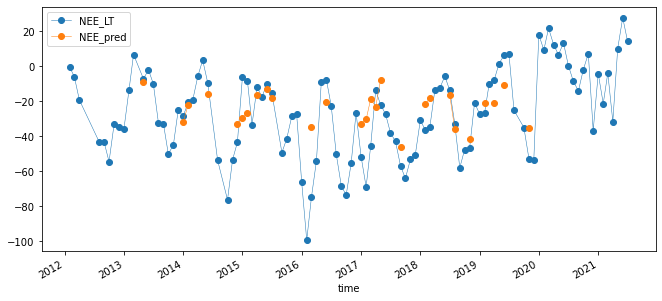

In [62]:
compare = pd.DataFrame(data=y_pred, index=y_test.index).rename({0:'NEE_pred'},axis=1)
df.join(compare).plot(y=['NEE_LT', 'NEE_pred'], figsize=(11,5), marker='o', linewidth=0.5);

## Fit on all data

In [51]:
ml_params = {
    'n_estimators': 400,
}

model = RandomForestRegressor(**ml_params)
model.fit(x, y)

RandomForestRegressor(n_estimators=500)

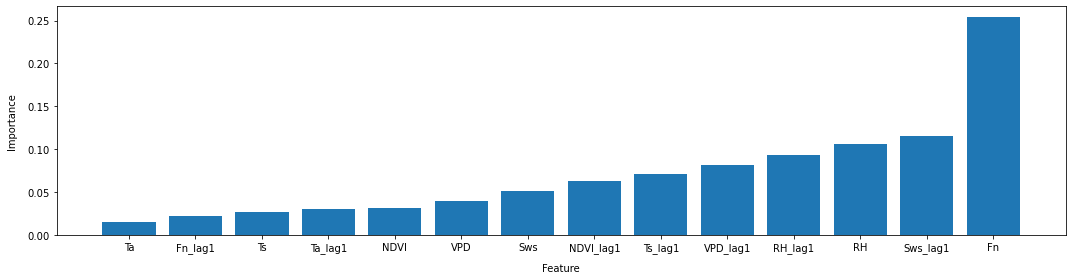

In [63]:
order = np.argsort(model.feature_importances_)

plt.figure(figsize=(15,4))
plt.bar(x=np.array(x.columns.values)[order],
        height=model.feature_importances_[order])
plt.gca().set_ylabel('Importance', labelpad=10)
plt.gca().set_xlabel('Feature', labelpad=10)
plt.tight_layout()

In [64]:
y_pred = model.predict(x)

RMSE: 10.606


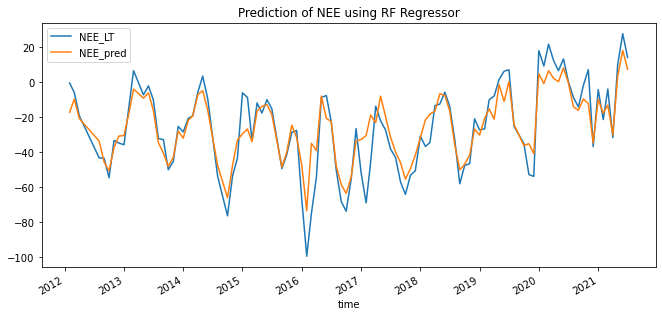

In [65]:
compare = pd.DataFrame(data=y_pred, index=df.index).rename({0:'NEE_pred'}, axis=1)
df.join(compare).plot(y=['NEE_LT', 'NEE_pred'], figsize=(11,5))
plt.title('Prediction of NEE using RF Regressor');

rmse = float(format(np.sqrt(mean_squared_error(y, y_pred)), '.3f'))
print("RMSE:", rmse);